In [26]:
import pandas as pd
import sympy as sym
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize

In [27]:
length = 6
width = 8
EUR = 0.84 # exchange rate

## Reading of the data
solar_panel_df = pd.read_csv("Optimisation\\Data\\solar_panels.csv")
# Unit conversion to make it consistent to the rest of the formulation
solar_panel_df["Power rating (kW)"] = solar_panel_df["Power rating (W)"]/1000
solar_panel_df["Area (m^2)"] = solar_panel_df["Length (m)"]*solar_panel_df["Width (m)"]
solar_panel_df["Price"] = solar_panel_df["Price (EUR)"]*EUR/30
solar_panel_df["Eff*A"] = solar_panel_df["Module Efficiency"]*solar_panel_df["Area (m^2)"]
# Cleaning up of the dataframe
del solar_panel_df["Power rating (W)"]
del solar_panel_df["OCV (V)"]
del solar_panel_df["SCC (A)"]
del solar_panel_df["Cells"]
del solar_panel_df["Thickness (m)"]
del solar_panel_df["Price (EUR)"]
del solar_panel_df["Annual Degradation (%)"]
del solar_panel_df["NOTC (C)"]
del solar_panel_df["P temp (%/C)"]
solar_panel_df.head()

,Name,Length (m),Width (m),Module Efficiency,Weight (kg),Power rating (kW),Area (m^2),Price,Eff*A
0,LG NeON2 340,1.686,1.016,0.198,18.0,0.340,1.712976,5.824,0.339169
1,LG NeON2 335,1.686,1.016,0.196,18.0,0.335,1.712976,6.020,0.335743
2,LG Mono X Plus 330,1.686,1.016,0.175,18.0,0.300,1.712976,4.816,0.299771
3,LG Mono X Plus 295,1.686,1.016,0.172,18.0,0.295,1.712976,4.648,0.294632
4,LG Neon R 370,1.700,1.016,0.214,18.5,0.370,1.727200,9.632,0.369621


maximum length of solar panel:  2.064
minimum length of solar panel:  1.463
maximum roof side length:  11.16171243850138
minimum roof side length:  4.256711089903647
(36, 9)
1.686


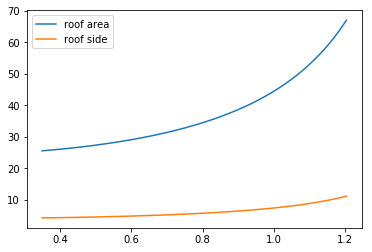

In [28]:
def roof_width(width, beta):
    return (width*np.sin(beta))/np.sin(np.pi-2*beta)

min_ang = np.deg2rad(20)
max_ang = np.deg2rad(70)
roof_angle = np.arange(min_ang, max_ang, np.deg2rad(1))

plt.plot(roof_angle, length*roof_width(width, roof_angle), label = "roof area")
plt.plot(roof_angle, roof_width(width, roof_angle), label="roof side")
plt.legend(loc="best")

print("maximum length of solar panel: ", solar_panel_df["Length (m)"].max())
print("minimum length of solar panel: ", solar_panel_df["Length (m)"].min())
print("maximum roof side length: ", max(roof_width(width, roof_angle)))
print("minimum roof side length: ", min(roof_width(width, roof_angle)))
print(solar_panel_df.shape)
print(solar_panel_df.iloc[0]["Length (m)"])

In [29]:
def max_tiling(p_length, p_width, r_length, r_width):
    if r_width >= p_length:
        # if the panels can be fitted perpendicularly
        number = np.floor(r_width/p_length)*np.floor(r_length/p_width)
        if r_width-p_length*np.floor(r_width/p_length) >= p_width:
            # if more panels can be fitted parallely in the remaining space
            number = number + np.floor(r_width-p_length*np.floor(r_width/p_length)/p_width)
    elif r_width >= p_width:
        # otherwise if we can fit the panels parallely
        number = np.floor(r_width/p_width)*np.floor(r_length/p_length)
    else: number = 0
    return number


# do not need symbolic integration as they are daily averages

def bills(energy, consumption, domain):    
    buy_price = 12.5/100 #grid power selling price/kWh
#     sell_price = 5.5/100 #grid power buying price/kWh
    sell_price = 12.5/100 #grid power buying price/kWh
    cost = 0 # initialising costs
    sell = 0
    needed = 0
    for i in np.arange(domain[0],domain[1]):
        difference = consumption(i)-energy(i)
        needed = needed+consumption(i)
        if difference > 0:
            # if there is more consumption than energy generated
            cost = cost + difference*buy_price
        else:
            # if the excess energy can be sold back to the grid
            sell = sell + difference*sell_price
    return cost-sell

In [30]:
# determine the maximum possible costs of purchasing solar panels
# Max roof area happens when max roof angle

max_roof_width = roof_width(width, max_ang)
min_roof_width = roof_width(width, min_ang)
print("max area: ", max_roof_width*length)
print("min area: ", min_roof_width*length)
num_models = solar_panel_df.shape[0] #number of solar panels in the data set
max_tile = []
min_tile = []
for i in range(num_models):
#     print("length: ", solar_panel_df.iloc[i]["Length (m)"])
#     print("width: ", solar_panel_df.iloc[i]["Width (m)"])
    max_tile.append(max_tiling(solar_panel_df.iloc[i]["Length (m)"], \
                               solar_panel_df.iloc[i]["Width (m)"], length, max_roof_width))
    min_tile.append(max_tiling(solar_panel_df.iloc[i]["Length (m)"], \
                               solar_panel_df.iloc[i]["Width (m)"], length, min_roof_width))
# print(max_tile)
solar_panel_df.insert(solar_panel_df.shape[1],"max tiles", max_tile) # figure out the 
solar_panel_df.insert(solar_panel_df.shape[1],"min tiles", min_tile) # figure out the 
solar_panel_df.head()

max area:  70.17130560391408
min area:  25.540266539421886


,Name,Length (m),Width (m),Module Efficiency,Weight (kg),Power rating (kW),Area (m^2),Price,Eff*A,max tiles,min tiles
0,LG NeON2 340,1.686,1.016,0.198,18.0,0.340,1.712976,5.824,0.339169,31.0,10.0
1,LG NeON2 335,1.686,1.016,0.196,18.0,0.335,1.712976,6.020,0.335743,31.0,10.0
2,LG Mono X Plus 330,1.686,1.016,0.175,18.0,0.300,1.712976,4.816,0.299771,31.0,10.0
3,LG Mono X Plus 295,1.686,1.016,0.172,18.0,0.295,1.712976,4.648,0.294632,31.0,10.0
4,LG Neon R 370,1.700,1.016,0.214,18.5,0.370,1.727200,9.632,0.369621,31.0,10.0


In [31]:
print("max area: ", max_roof_width*length, " width: ", max_roof_width)
print("min area: ", min_roof_width*length, " width: ", min_roof_width)

max area:  70.17130560391408  width:  11.695217600652347
min area:  25.540266539421886  width:  4.256711089903647


In [32]:
solar_panel_df["max cost"] = (solar_panel_df["max tiles"]*solar_panel_df["Price"])
print(solar_panel_df["max cost"].max())
# with the maximum amount of panels purchased, the maximum yearly cost across 25 years is £138.7
# This show that while the costs of solar panels is much smaller than the 

334.768


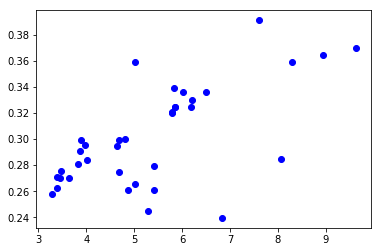

In [33]:
plt.plot(solar_panel_df["Price"],solar_panel_df["Eff*A"],"bo")


In [34]:
print(solar_panel_df["Price"][solar_panel_df["Price"].argsort()[::1]])

23    3.276
24    3.388
11    3.388
21    3.444
12    3.472
20    3.640
13    3.836
14    3.864
18    3.892
15    3.976
27    4.004
3     4.648
19    4.676
16    4.676
2     4.816
9     4.872
22    5.012
10    5.012
28    5.292
26    5.404
25    5.404
33    5.796
7     5.796
0     5.824
31    5.852
35    5.852
1     6.020
32    6.188
30    6.216
17    6.496
29    6.832
8     7.616
34    8.064
6     8.288
5     8.932
4     9.632
Name: Price, dtype: float64


In [35]:
def pareto_set(name, data_1, data_2, min1=True, min2=True):
    # sort by data_1 to find the dominating points
    if min1 == True:
        index = data_1.argsort()[::1]
        data_1 = data_1[index] #sort from largest to smallest
        data_2 = data_2[index]
        name = name[index]
    else: 
        index = data_1.argsort()[::-1]
        data_1 = data_1[index] #sort from smallest to largest
        data_2 = data_2[index]
        name = name[index[::1]]
#     print(data_1)
#     print("first data: ", data_1[index[0]], " ", data_2[index[0]], " ", name[index[0]])
#     print(index)
#     print(index[len(index)-1])
    pareto = [index[len(index)-1]]
    name_set = [name[index[0]]]
    ref = data_2[index[0]]
    for i in np.arange(1,len(data_1)):
        if min2==True:
            if data_2[index[i]]<ref:
                pareto.append(index[len(index)-1-i])
                ref = data_2[index[i]]
                name_set.append(name[index[i]])
        else:
            if data_2[index[i]]>ref:
                pareto.append(index[len(index)-1-i])
                ref = data_2[index[i]]
                name_set.append(name[index[i]])
    return pareto, name_set


In [36]:
# any solar panels not in this set are not as cost effective
pareto = pareto_set(solar_panel_df["Name"],solar_panel_df["Price"], \
                    solar_panel_df["Eff*A"],min1=True, min2=False)
# print(pareto[0])
# print(pareto[1])

23    3.276
24    3.388
11    3.388
21    3.444
12    3.472
20    3.640
13    3.836
14    3.864
18    3.892
15    3.976
27    4.004
3     4.648
19    4.676
16    4.676
2     4.816
9     4.872
22    5.012
10    5.012
28    5.292
26    5.404
25    5.404
33    5.796
7     5.796
0     5.824
31    5.852
35    5.852
1     6.020
32    6.188
30    6.216
17    6.496
29    6.832
8     7.616
34    8.064
6     8.288
5     8.932
4     9.632
Name: Price, dtype: float64
first data:  3.2760000000000002   0.25782075000000004   Trina Honey TSM 270


In [37]:
# As there are only three solar panels in the pareto set
# Needed to be expanded for regression determining the relationship between price and power generation
# for panel_model in pareto:
#     print(solar_panel_df[solar_panel_df["Name"]==panel_model])
pareto_df = solar_panel_df.loc[solar_panel_df['Name'].isin(pareto[1])]
pareto_df = pareto_df.sort_values(by=["Price"])

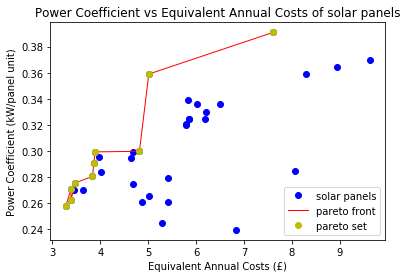

In [58]:
plt.plot(solar_panel_df["Price"],solar_panel_df["Eff*A"],"bo", label = "solar panels")
plt.plot(pareto_df["Price"],pareto_df["Eff*A"],"r-", label = "pareto front", linewidth=1)
plt.plot(pareto_df["Price"],pareto_df["Eff*A"],"yo", label = "pareto set")
plt.legend(loc="best")
plt.title("Power Coefficient vs Equivalent Annual Costs of solar panels")
plt.xlabel("Equivalent Annual Costs (£)")
plt.ylabel("Power Coefficient (kW/panel unit)")
plt.show()

In [40]:
def fit_log(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    def log_func(x, a, b, c):
        return a * np.log(b * x) + c

    popt, pcov = optimize.curve_fit(log_func, tt, yy)
    a, b, c = popt
    fitfunc = lambda x: a * np.log(b * x) + c
    return {"a": a, "b": b, "c": c,
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (popt,pcov)}

def fit_exp(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    def exp_func(x, a, b, c):
        return a * np.exp(b * x) + c
    popt, pcov = optimize.curve_fit(exp_func, tt, yy)
    a, b, c = popt
    fitfunc = lambda x: a * np.exp(b * x) + c
    return {"a": a, "b": b, "c": c,
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (popt,pcov)}

def fit_lin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    def exp_func(x, a, b):
        return a * x + b
    popt, pcov = optimize.curve_fit(exp_func, tt, yy)
    a, b = popt
    fitfunc = lambda x: a * x + b
    return {"a": a, "b": b,
            "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (popt,pcov)}

28.5307800452928
-4.265292541194691
<function <lambda> at 0x0000029C6C3DD6A8>


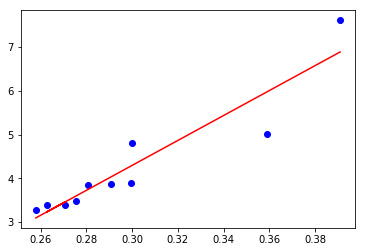

In [41]:
x_data = pareto_df["Price"]
y_data = pareto_df["Eff*A"]
# print(x_data)
# print(y_data)
pareto_front = fit_lin(pareto_df["Eff*A"],pareto_df["Price"])
# pareto_fit = lambda x: pareto_front["a"]*np.exp(pareto_front["b"]*x)+pareto_front["c"]
pareto_fit = lambda x: pareto_front["a"]*x+pareto_front["b"]
print(pareto_front["a"])
print(pareto_front["b"])
print(pareto_fit)
plt.plot(pareto_df["Eff*A"], pareto_df["Price"], 'bo')
plt.plot(pareto_df["Eff*A"], pareto_front["fitfunc"](pareto_df["Eff*A"]), 'r-')
# not a good fit but worth trying

In [42]:
# consumption_fit = 1.30338864562213*sym.sin(0.0172004453662375*t + 1.62737939447036) + 11.9623058930769
# solar_fit = 5.62575334261198*sin(0.01716050340221*t - 1.34948474433562) + 10.2277234035447
# pareto_fit = 0.0560335267904956*exp(19.7798406889663*x) + 96.2783894507582
# roof_factor = sin(np.pi/2-np.deg2rad(latitude)+delta(t)+beta)
# delta = np.deg2rad(23.45)*np.sin(np.deg2rad((360/365)*(t/24-81)))
consumption_fit = lambda t: 1.30338864562213 * np.sin(0.0172004453662375*t + 1.62737939447036) + 11.9623058930769
solar_fit = lambda t: 0.2*(5.62575334261198 * np.sin(0.01716050340221*t - 1.34948474433562) + 10.2277234035447)
delta = lambda t: np.deg2rad(23.45)*np.sin(np.deg2rad((360/365)*(t/24-81)))
roof_factor = lambda beta, t: np.sin(np.pi/2-np.deg2rad(latitude)+delta(t)+beta)

beta = np.deg2rad(20)
latitude = np.deg2rad(50.41)
gen_rate = np.arange(0.24, 1.4, 0.05)
panel_costs = []
energy_costs = []
total_costs = []
roof_life = 30
roof_unit_costs = 90


for i in gen_rate:
    generation = lambda t: i*np.sin(np.pi/2-np.deg2rad(latitude)+delta(t)+beta)*solar_fit(t)
    energy_cost = bills(generation,consumption_fit,[0, 365])
    panel_cost = pareto_fit(i)+roof_width(width, beta)*length*roof_unit_costs/roof_life
    energy_costs.append(energy_cost)
    panel_costs.append(panel_cost)
    total_costs.append(energy_cost+panel_cost)

    


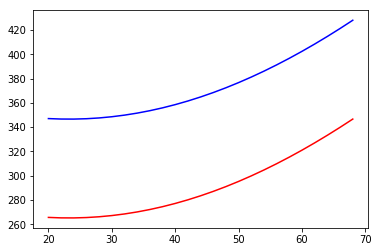

In [59]:
beta = np.arange(min_ang, max_ang, np.deg2rad(2))
latitude = np.deg2rad(50.41)
gen_rate = 3
panel_costs = []
energy_costs = []
total_costs = []
for i in beta:
    generation = lambda t: gen_rate*np.sin(np.pi/2-np.deg2rad(latitude)+delta(t)+i)*solar_fit(t)
    energy_cost = bills(generation,consumption_fit,[0, 365])
    panel_cost = pareto_fit(gen_rate)#+roof_width(width, i)*length*roof_unit_costs/roof_life
    energy_costs.append(energy_cost)
    panel_costs.append(panel_cost)
    total_costs.append(energy_cost+panel_cost)
    
plt.plot(np.rad2deg(beta), energy_costs, 'r-')
plt.plot(np.rad2deg(beta), total_costs, 'b-')

## proves that it is a linear problem that is not interesting


In [61]:
pareto_df.shape
overall_start=time.time()
beta = np.arange(np.deg2rad(20), np.deg2rad(25), np.deg2rad(0.1))

for i in range(pareto_df.shape[0]):
    no_panels = np.array([])
    roof_angs = np.array([])
    total_costs = np.array([])

    start_time = time.time()
    for j in beta:
        # loop through the beta
        max_panels = max_tiling(pareto_df.iloc[i]["Length (m)"],pareto_df.iloc[i]["Width (m)"],\
                               length, roof_width(width, j))
#         print("Model: %s; roof angle: %.2f; max panels: %d" %(pareto_df.iloc[i]["Name"],np.rad2deg(j),max_panels))

        for k in range(int(max_panels)):
            generation = lambda t: k*pareto_df.iloc[i]["Eff*A"]*np.sin(np.pi/2-np.deg2rad(latitude)+delta(t)+j)*solar_fit(t)
            energy_cost = bills(generation,consumption_fit,[0, 365])
            panel_cost = k*pareto_df.iloc[i]["Price"]#+roof_width(width, j)*length*roof_unit_costs/roof_life
            no_panels = np.append(no_panels,k)
            roof_angs = np.append(roof_angs,j)
            total_costs = np.append(total_costs,energy_cost+panel_cost)
#             print("No. Panels: %d; energy cost: %.2f; panel cost: %.2f" %(k,energy_cost,panel_cost))


    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')

    # ax.scatter(no_panels, roof_angs, total_costs, c='r', marker='o')

    # ax.set_xlabel('Number of Panels')
    # ax.set_ylabel('Roof angle')
    # ax.set_zlabel('total_costs')

    # plt.show()

    index = total_costs.argsort()[::1]
    total_costs = total_costs[index] #sort from largest to smallest
    no_panels = no_panels[index]
    roof_angs = roof_angs[index]
    print("Model: %s; minimum cost: %.2f; no. of panels: %d; roof angle: %.2f" 
          %(pareto_df.iloc[i]["Name"],total_costs[0], no_panels[0],np.rad2deg(roof_angs[0])))
    
    print("--- loop %d: %s seconds ---" % (i, time.time() - start_time))
print("--- total: %s seconds ---" % (time.time() - overall_start))

Model: Trina Honey TSM 270; minimum cost: 316.65; no. of panels: 11; roof angle: 23.20
--- loop 0: 35.86023712158203 seconds ---
Model: REC Peak Energy PE 270; minimum cost: 282.83; no. of panels: 12; roof angle: 23.50
--- loop 1: 37.85350775718689 seconds ---
Model: Trina Honey TSM 275; minimum cost: 313.06; no. of panels: 11; roof angle: 23.20
--- loop 2: 40.73502802848816 seconds ---
Model: REC Peak Energy PE 275; minimum cost: 278.29; no. of panels: 12; roof angle: 23.50
--- loop 3: 38.87403678894043 seconds ---
Model: REC TwinPeak 2 280; minimum cost: 277.05; no. of panels: 12; roof angle: 23.50
--- loop 4: 39.64942502975464 seconds ---
Model: REC TwinPeak 2 290; minimum cost: 269.02; no. of panels: 12; roof angle: 23.50
--- loop 5: 35.803361892700195 seconds ---
Model: Sharp NU-AK 300; minimum cost: 263.92; no. of panels: 12; roof angle: 23.20
--- loop 6: 36.34279417991638 seconds ---
Model: LG Mono X Plus 330; minimum cost: 313.71; no. of panels: 10; roof angle: 24.30
--- loop 7

In [60]:
target = 3
for i in range(pareto_df.shape[0]):
    number = np.ceil(target/pareto_df.iloc[i]["Eff*A"])
    cost = number*pareto_df.iloc[i]["Price"]
    print("model: %s; cost: %.2f; number: %d" %(pareto_df.iloc[i]["Name"],cost, number))

model: Trina Honey TSM 270; cost: 39.31; number: 12
model: REC Peak Energy PE 270; cost: 40.66; number: 12
model: Trina Honey TSM 275; cost: 37.27; number: 11
model: REC Peak Energy PE 275; cost: 38.19; number: 11
model: REC TwinPeak 2 280; cost: 42.20; number: 11
model: REC TwinPeak 2 290; cost: 42.50; number: 11
model: Sharp NU-AK 300; cost: 38.92; number: 10
model: LG Mono X Plus 330; cost: 48.16; number: 10
model: Sharp NDSC 360; cost: 45.11; number: 9
model: LG NeON 2 BiFacial 390; cost: 60.93; number: 8
